# Assignment 2:  Autoregressive Models

## Charlie Becker

## GEOS 518

## 03-07-18

#### Import relevant packages and extract data

In [2]:
import numpy as np
import xarray as xr # used to help convert NetCDF data to dataframe structure
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as sm
from pandas.core import datetools

a = xr.open_dataset('30_year_point_Q2.nc')

data = a.to_dataframe()  # create dataframe
Q2 = data['Q2'].values   # pull water vapor values

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  import sys


#### Plot overall structure of time series data 

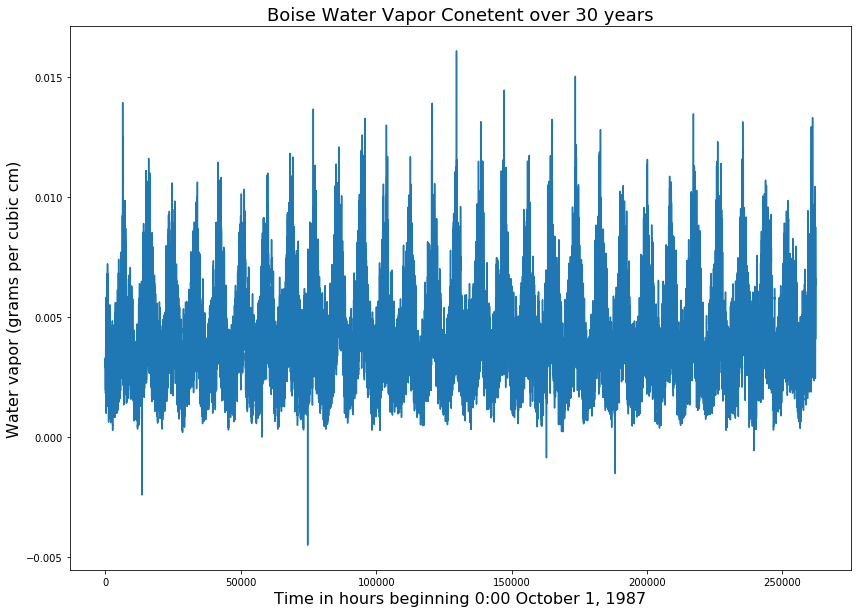

In [3]:
# Plot and label Q2 data
plt.figure(figsize=(14,10))
plt.title('Boise Water Vapor Conetent over 30 years',fontsize=18)
plt.ylabel('Water vapor (grams per cubic cm)', fontsize=16)
plt.xlabel('Time in hours beginning 0:00 October 1, 1987', fontsize=16)
plt.plot(Q2)
plt.show()

#### Split data into a trainging and test set (28 years training and 2 years to test)

In [4]:
train_Q2 = Q2[0:(262302-(24*365*2))] 
test_Q2 = Q2[-(24*365*2):]

#### Create autocorrelation function (for first two years)

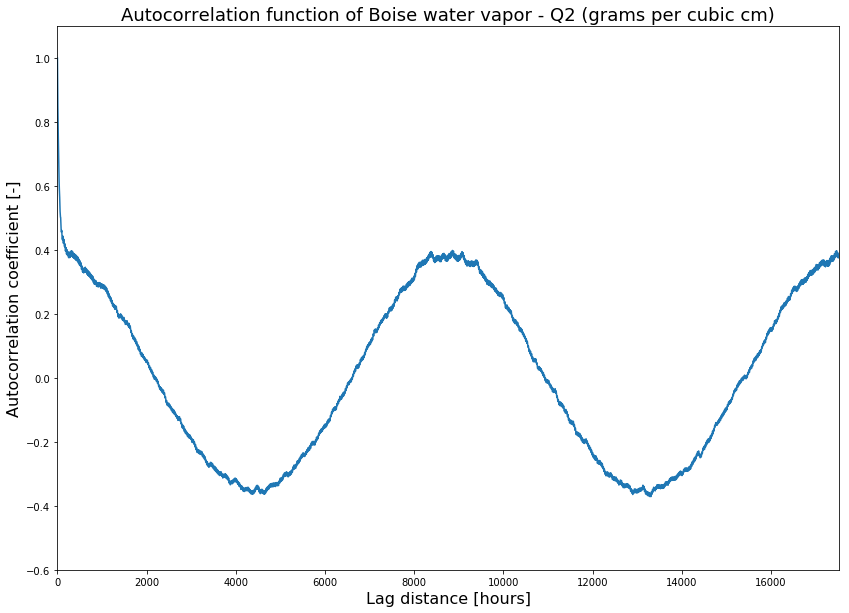

In [5]:
# Create sequences for looping through Q2 array
Nk = 24*365*2
K  = np.arange(0,Nk,1)
Rk = np.zeros((Nk,1))

# Loop to create correlation coefficients for each lag from 1 - Nk
for k in K:
    q = train_Q2[k:-1] 
    q1 = train_Q2[0:-(1+k)]
    R = np.corrcoef(q,q1)
    Rk[k] = R[1,0]
  
    
# Plot Autocorrelation funciton    
plt.figure(figsize=(14,10))
plt.plot(K,Rk)
plt.xlim(0.0,np.amax(K.astype(float)))
plt.ylim(-.6,1.1)
plt.title('Autocorrelation function of Boise water vapor - Q2 (grams per cubic cm)',fontsize=18)
plt.xlabel('Lag distance [hours]',fontsize=16)
plt.ylabel('Autocorrelation coefficient [-]',fontsize=16)
plt.show()

#### Calculate and print correlation coefficient of lags 1 and 2 hours to compare to model coefficients

In [38]:
q = train_Q2[0:-2]
q1 = train_Q2[1:-1]
R1 = np.corrcoef(q,q1)
print('The correlation coefficient of values lagged by 1 hour is:',R1[1,0])

q = train_Q2[0:-3]
q1 = train_Q2[2:-1]
R2 = np.corrcoef(q,q1)
print('The correlation coefficient of values lagged by 2 hours is:',R2[1,0])

The correlation coefficient of values lagged by 1 hour is: 0.977730169095
The correlation coefficient of values lagged by 2 hours is: 0.957905376486


#### Estimate AR (of order 2) parameters (phi) with Yule-Walker approximation equations

In [39]:
phi_1 = (1-((R1[1,0]**2-R2[1,0])/(R1[1,0]**2-1)))*R1[1,0]
phi_2 = (R1[1,0]**2-R2[1,0])/(R1[1,0]**2-1)


print(phi_1)
print(phi_2)

0.934462091105
0.044253598137


#### Estimate AR model parameters with the stats model package

In [40]:
Q_AR1_model = sm.AR(train_Q2).fit(1)
print(Q_AR1_model.params)

Q_AR2_model = sm.AR(train_Q2).fit(2)
print(Q_AR2_model.params)

[  8.56978117e-05   9.77729533e-01]
[  8.19025835e-05   9.34465452e-01   4.42500175e-02]


#### Note that they match up quite well.  Phi of the order one model (.9777 is the same as the correlation coefficient of lag one.  Phi 1 and 2 also match closely with the approxmtions given by the Yule-Walker approximations. 

#### Calculate and print the error statistics (R sqaured, average error and standard deviation)

In [42]:
R2_AR1 = np.corrcoef(Q2_AR1, test_Q2[:101])**2
R2_AR2 = np.corrcoef(Q2_AR2, test_Q2[:101])**2

avgError_AR1 = np.mean(Q2_AR1 - test_Q2[:101])
avgError_AR2 = np.mean(Q2_AR2 - test_Q2[:101])

stdError_AR1 = np.std(Q2_AR1 - test_Q2[:101])
stdError_AR2 = np.std(Q2_AR2 - test_Q2[:101])

percentError = np.mean(np.absolute(test_Q2[:101] - Q2_AR1)/test_Q2[:101])*100

print(R2_AR1[1,0],R2_AR2[1,0],avgError_AR1,avgError_AR2,stdError_AR1,stdError_AR2,percentError)



0.858613700979 0.857338864705 -1.47632e-05 -1.44064e-05 0.000255666 0.000256678 4.13293465972


#### Use stats package to pull model parameters and plot modeled timeseries over observed series

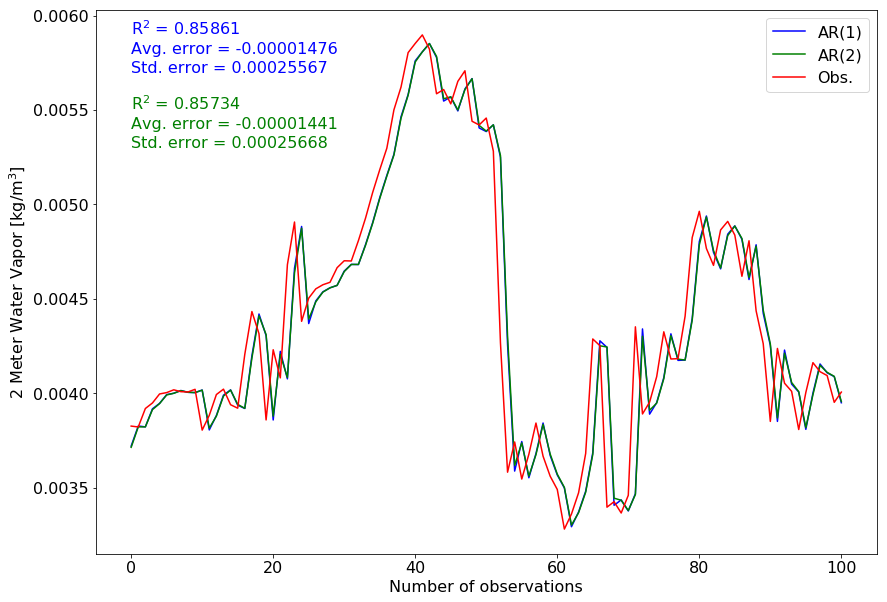

In [46]:
# Concatenate lagged series to match length 

AR1_cat = np.concatenate([train_Q2[-2:-1],test_Q2[0:100]])  
AR2_cat = np.concatenate([train_Q2[-3:-1],test_Q2[0:99]])

# pull model parameters for AR(1)
AR1_mu   = Q_AR1_model.params[0]
AR1_phi1 = Q_AR1_model.params[1]

# create model
Q2_AR1 = AR1_mu + AR1_phi1*AR1_cat

# pull model parameters for AR(2)
AR2_mu   = Q_AR2_model.params[0]
AR2_phi1 = Q_AR2_model.params[1]
AR2_phi2 = Q_AR2_model.params[2]

# create model for AR(2)
Q2_AR2 = AR2_mu + AR2_phi1*AR1_cat + AR2_phi2*AR2_cat

plt.figure(figsize=(14,10))

plt.plot(Q2_AR1,'b-')
plt.plot(Q2_AR2,'g-')
plt.plot(test_Q2[:101],'r-')
plt.ylabel('2 Meter Water Vapor [kg/m${}^3$]',fontsize=16)
plt.xlabel('Number of observations',fontsize=16)
plt.legend(('AR(1)','AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)

# Add error statistics
ax.annotate('R${}^2$ = %.5f'%R2_AR1[0,1], xy=(0,.0059), fontsize=16, color = 'b')
ax.annotate('Avg. error = %.8f'%avgError_AR1, xy=(0,.0058), fontsize=16, color = 'b')
ax.annotate('Std. error = %.8f'%stdError_AR1, xy=(0,.0057), fontsize=16, color = 'b')
ax.annotate('R${}^2$ = %.5f'%R2_AR2[0,1], xy=(0,.0055), fontsize=16, color = 'g')
ax.annotate('Avg. error = %.8f'%avgError_AR2, xy=(0,.0054), fontsize=16, color = 'g')
ax.annotate('Std. error = %.8f'%stdError_AR2, xy=(0,.0053), fontsize=16, color = 'g')
plt.show()


#### There is vey little difference between the order 1 and order 2 autoregressive models for this time series.  It's nearly a perfect overlay and can be confirmed through the error statistics.  In line with parsimony, I believe the second order model does not appear to add any significant power, and thus the AR(1) would be considered the best model here. The relatively good R squared values of .85 represent the lagged response since the primary drivers of these models are the immeadiate preceding values.  The lag is quite obvious in the plot, and a shift of the models back 1 or even 2 timesteps would most likely have an R squared value much closer to 1.  